In [1]:
%cd "/workspace/src"

/workspace/src


In [2]:
from cvl.dataset import OnlineTrackingBenchmark
from mosse import MOSSETrackerGrayscale
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from scipy.stats import norm
from cvl.image_io import crop_patch
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [3]:
dataset_path = "../data/Mini-OTB"
dataset = OnlineTrackingBenchmark(dataset_path)
SEQUENCE_IDX = 5
a_seq = iter(dataset[SEQUENCE_IDX])
first_frame = next(a_seq)
frame_idx = 1

In [4]:
std = 5
learning_rate = 0.05
BBOX_ENLARGE_FACTOR = 3.0
tracker = MOSSETrackerGrayscale(std=std, learning_rate=learning_rate)

In [5]:
image = np.sum(first_frame["image"], 2) / 3
bbox = first_frame["bounding_box"]
bbox.__dict__

{'xpos': 478, 'ypos': 143, 'width': 80, 'height': 111}

In [6]:
bbox.xpos -= int(bbox.width * (BBOX_ENLARGE_FACTOR - 1) / 2)
bbox.width = int(bbox.width * BBOX_ENLARGE_FACTOR)
bbox.ypos -= int(bbox.height * (BBOX_ENLARGE_FACTOR - 1) / 2)
bbox.height = int(bbox.height * BBOX_ENLARGE_FACTOR)
if bbox.width % 2 == 0:
    bbox.width += 1

if bbox.height % 2 == 0:
    bbox.height += 1

In [7]:
bbox.__dict__

{'xpos': 398, 'ypos': 32, 'width': 241, 'height': 333}

## Start

In [8]:
# Where the gaussian should be centered
region = bbox
region_center = (region.height // 2, region.width // 2)

C = MOSSETrackerGrayscale.get_fourier_transformed_gaussian(height=region.height, width=region.width, std=std,
                                   mean_x=0, mean_y=0)

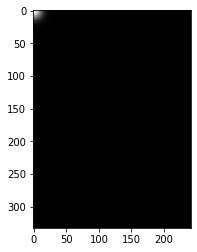

In [9]:
plt.imshow(np.abs(C), cmap="gray")

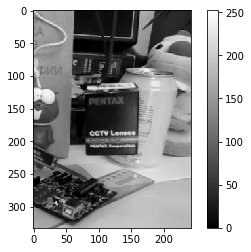

In [10]:
patch = crop_patch(image, region)
plt.imshow(patch, cmap="gray")
plt.colorbar()

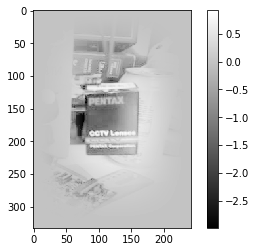

In [11]:
normalized_patch = MOSSETrackerGrayscale.normalize(patch)
plt.imshow(normalized_patch, cmap="gray")
plt.colorbar()

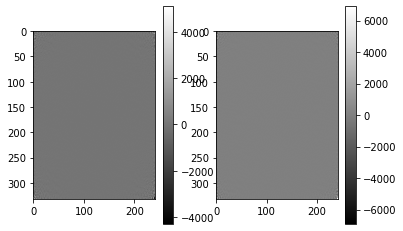

In [12]:
P = fft2(normalized_patch)
plt.subplot(121)
plt.imshow(np.real(P), cmap="gray")
plt.colorbar()
plt.subplot(122)
plt.imshow(np.imag(P), cmap="gray")
plt.colorbar()

In [13]:
A = np.conjugate(C) * P
B = np.conjugate(P) * P

# MOSSE update rule
M = A / B

# NCC update rule
#M = P

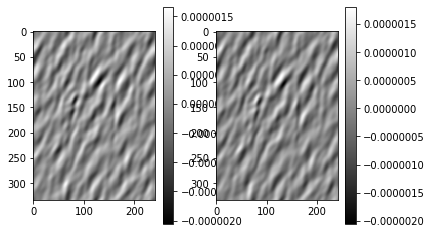

In [14]:
m = ifft2(M)
plt.subplot(121)
plt.imshow(np.real(m), cmap="gray")
plt.colorbar()
plt.subplot(122)
plt.imshow(np.imag(m), cmap="gray")
plt.colorbar()

## Detect

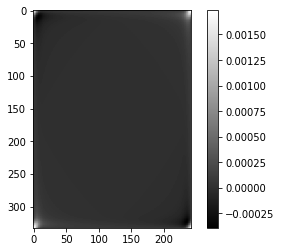

In [15]:
response = ifft2( np.conjugate(M) * P )
plt.imshow(np.real(response), cmap="gray")
plt.colorbar()

In [16]:
r, c = np.unravel_index(np.argmax(response), response.shape)

r_offset = np.mod(r + region_center[0], region.height) - region_center[0]
c_offset = np.mod(c + region_center[1], region.width) - region_center[1]

print(f"r_offset: {r_offset}\tc_offset: {c_offset}")

r_offset: 0	c_offset: 0


## Detect in next frame

Press CTRL+Enter to step through the frames

Frame: 52
y: 330	x:4
r_offset: -3	c_offset: 4


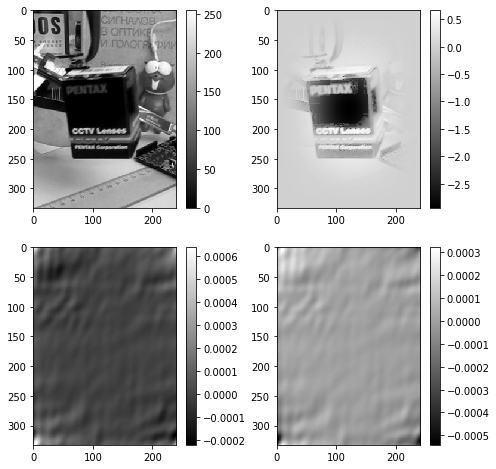

In [67]:
frame_idx += 1 
frame = next(a_seq)
image = np.sum(frame["image"], 2) / 3

plt.figure(figsize=(8, 8))

# Detect ---

patch = crop_patch(image, region)
plt.subplot(221)
plt.imshow(patch, cmap="gray")
plt.colorbar()

normalized_patch = MOSSETrackerGrayscale.normalize(patch)
plt.subplot(222)
plt.imshow(normalized_patch, cmap="gray")
plt.colorbar()

P = fft2(normalized_patch)
response = ifft2( np.conjugate(M) * P )
plt.subplot(223)
plt.imshow(np.real(response), cmap="gray")
plt.colorbar()
plt.subplot(224)
plt.imshow(np.imag(response), cmap="gray")
plt.colorbar()

r, c = np.unravel_index(np.argmax(response), response.shape)
r_offset = np.mod(r + region_center[0], region.height) - region_center[0]
c_offset = np.mod(c + region_center[1], region.width) - region_center[1]

print(f"Frame: {frame_idx}")
print(f"y: {r}\tx:{c}")
print(f"r_offset: {r_offset}\tc_offset: {c_offset}")

region.xpos += c_offset
region.ypos += r_offset

# Update --

patch = crop_patch(image, region)
normalized_patch = MOSSETrackerGrayscale.normalize(patch)
P = fft2(normalized_patch)

# MOSSE Update rule
A = A * (1-learning_rate) + np.conjugate(C) * P * learning_rate
B = B * (1-learning_rate) + np.conjugate(P) * P * learning_rate
M = A / B

# NCC Update rule
#M = M * (1-learning_rate) + P * learning_rate